# Algorithm Illustration

In [1]:
import os
import importlib
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

from utils.data import DataTree
import snapfish2 as sf
importlib.reload(sf)

<module 'snapfish2' from '/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/__init__.py'>

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
out_dire = "../123ACElog/040425"
dtree = DataTree("../data")

In [4]:
loader = sf.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"],
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250})
adata = loader.create_adata("chr3")
sf.pp.filter_normalize(adata)
adata

AnnData object with n_obs × n_vars = 910 × 60
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'
    varp: 'raw_var_X', 'raw_var_Y', 'raw_var_Z', 'count_X', 'count_Y', 'count_Z', 'var_X', 'var_Y', 'var_Z'

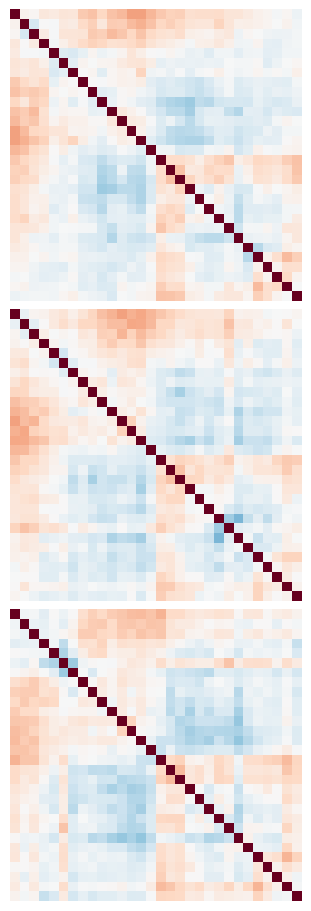

In [5]:
sub_adata = adata[:,::2]
fig, axes = plt.subplots(3, 1, figsize=(3, 9))
for i, key in enumerate(["var_X", "var_Y", "var_Z"]):
    sf.pl.pairwise_heatmap(sub_adata.varp[key], cmap="RdBu", 
                           vmax=2, ax=axes[i], cbar=False)
fig.savefig(os.path.join(out_dire, "varp_heatmap.pdf"), bbox_inches="tight")

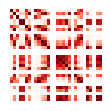

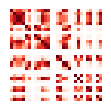

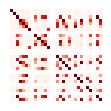

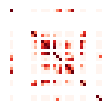

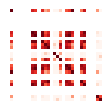

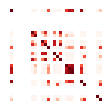

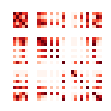

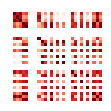

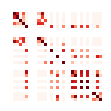

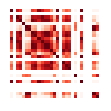

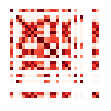

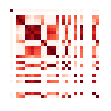

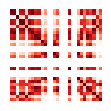

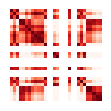

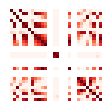

In [36]:
arr = np.stack([adata[:,:30].layers[c] for c in ["X", "Y", "Z"]])
for i in range(5):
    for j, x in enumerate(np.abs(arr[:,i*10,:,None] - arr[:,i*10,None,:])):
        fig, ax = plt.subplots(figsize=(1, 1))
        sf.pl.pairwise_heatmap(x, vmax=20, ax=ax, cbar=False, cmap="Reds_r")
        fig.savefig(os.path.join(out_dire, f"pairwise_diff_{i}_{j}.pdf"), 
                    pad_inches=0, bbox_inches="tight")

In [6]:
import dask.array as da

In [111]:
loader = sf.pp.FOF_CT_Loader("../data/su_cell_2020/chromosome2.csv")
adata = loader.create_adata("chr2")

In [112]:
n = adata.shape[0]
# Size of n*d*c*c = 1GB
c = round(1 * (n * 3 * 8 / 1e9) ** -0.5)

val_cols = ["X", "Y", "Z"]
X = da.from_array(np.stack([
    adata.layers[c] for c in val_cols
]), chunks=(3,n,c))
arr = X[:,:,:,None] - X[:,:,None,:]


In [113]:
arr

dask.array<sub, shape=(3, 3029, 935, 935), dtype=float64, chunksize=(3, 3029, 117, 117), chunktype=numpy.ndarray>

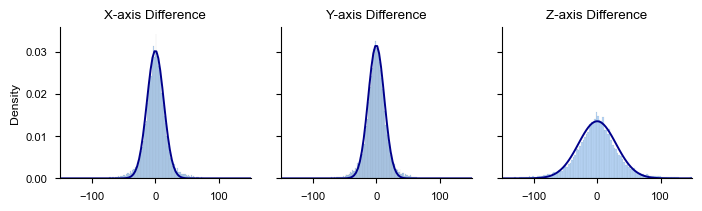

In [11]:
from scipy.stats import norm
d1d = adata.var["Chrom_Start"].values
idxs = np.where(d1d[:,None] - d1d[None,:] == 25e3)
X = np.stack([adata.layers[c] for c in ["X", "Y", "Z"]])
arr = X[:,:,:,None] - X[:,:,None,:]
parr = arr[:,:,idxs[0], idxs[1]]
fig, axes = plt.subplots(1, 3, figsize=(7, 2), sharey=True)
for i, c in enumerate(["X", "Y", "Z"]):
    color = sns.palettes.color_palette("pastel")[0]
    sns.histplot(parr[i].flatten(), ax=axes[i], color=color, stat="density")
    # xlim = (-100, 100) if c != "Z" else (-250, 250)
    xlim = (-150, 150)
    axes[i].grid(False)
    axes[i].set(title=f"{c}-axis Difference", xlim=xlim)
    
    mid = parr[i][np.abs(parr[i]) < 2*np.nanstd(parr[i])]
    mean, var = np.nanmean(mid), np.nanvar(mid)
    
    x = np.linspace(*axes[i].get_xlim(), 100)
    y = norm.pdf(x, mean, np.sqrt(var))
    
    axes[i].plot(x, y, color='darkblue')
fig.savefig(os.path.join(out_dire, "25Kb_diff_hist.pdf"), bbox_inches="tight")

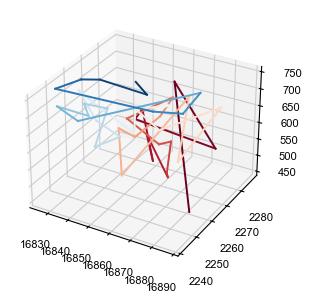

In [22]:
from matplotlib import cm
from matplotlib.colors import Normalize

X = np.stack([adata[0].layers[c][0] for c in ["X", "Y", "Z"]])
tdf = pd.DataFrame(X.T, columns=["X", "Y", "Z"]).reset_index().dropna()

# Normalize the "index" column for the colormap
norm = Normalize(vmin=tdf["index"].min(), vmax=tdf["index"].max())
colors = cm.RdBu(norm(tdf["index"]))

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection="3d")

# Plot the 3D curve with the color gradient
for i in range(len(tdf) - 1):
    ax.plot(
        tdf["X"].iloc[i:i+2],
        tdf["Y"].iloc[i:i+2],
        tdf["Z"].iloc[i:i+2],
        color=colors[i]
    )
fig.savefig(os.path.join(out_dire, "25Kb_3d.pdf"), bbox_inches="tight")

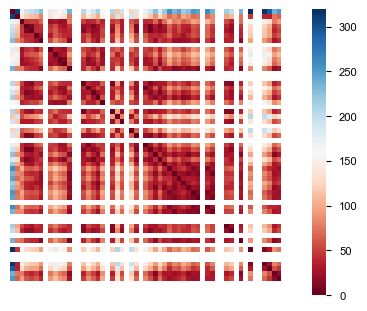

In [107]:
d = np.sqrt(np.sum(np.square(X[:,:,None] - X[:,None,:]), axis=0))
fig, ax = plt.subplots(figsize=(4, 3))
sf.pl.pairwise_heatmap(d, ax=ax, cmap="RdBu")
fig.savefig(os.path.join(out_dire, "25Kb_dist.pdf"), bbox_inches="tight")

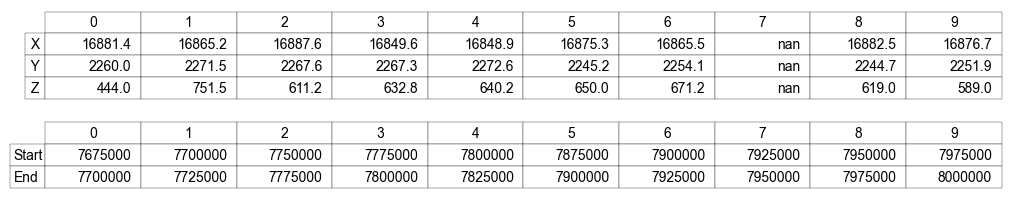

In [95]:
fig, axes = plt.subplots(2, 1, figsize=(10, 2))
axes[0].table(cellText=X[:,:10].round(1), 
         colLabels=range(10), rowLabels=[" X ", " Y ", " Z "],
         loc="center")
axes[0].set(xticks=[], yticks=[], frame_on=False)
axes[0].grid(False)
axes[1].table(cellText=adata.var.iloc[:10].values.T, 
         colLabels=range(10), rowLabels=["Start", "End"],
         loc="center")
axes[1].set(xticks=[], yticks=[], frame_on=False)
axes[1].grid(False)
fig.savefig(os.path.join(out_dire, "25Kb_example.pdf"), bbox_inches="tight")

In [1]:
import os
import importlib
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

import zarr
import dask.array as da

from utils.data import DataTree
import snapfish2 as sf
importlib.reload(sf)

snapfish2.plot


<module 'snapfish2' from '/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/__init__.py'>

In [2]:
%reload_ext autoreload
%autoreload 2

In [4]:
sf.__name__

'snapfish2'

In [3]:
out_dire = "../123ACElog/013125"

In [4]:
dtree = DataTree("../data")
dfs = []
for k in ["rep1", "rep2"]:
    data_name = dtree["takei_nature_2021","25Kb",k]
    df = sf.MulFish(data_name).data
    df["Trace_ID"] = k + "_" + df["Trace_ID"]  # Ensure Trace_ID is unique
    df["Replicate"] = k
    df["X"] *= 103; df["Y"] *= 103; df["Z"] *= 250  # Convert to nm
    dfs.append(df)
mfr = sf.MulFish(pd.concat(dfs, ignore_index=True))
del df, dfs

## Comparison of different outlier removing strategies

In [5]:
def to_var_df(arr, d1d, func=np.nanvar):
    d1map = d1d[None,:] - d1d[:,None]
    ls = {"axis":[], "1d":[], "var":[], "n":[]}
    for i in range(arr.shape[1]):
        for d in np.unique(d1map[d1map>0]):
            ls["axis"].append(i)
            ls["1d"].append(d)
            sub_arr = arr[:,i,:,:][:,d1map==d]
            ls["var"].append(func(sub_arr))
            ls["n"].append(np.sum(~np.isnan(sub_arr)))
    return pd.DataFrame(ls)

In [6]:
chr_df = mfr["chr3"]
chr_df_pivoted, arr = sf.utils.load.to_very_wide(chr_df)
d1d = chr_df_pivoted.index.values
nstds = 4

1. divide by the sample variance

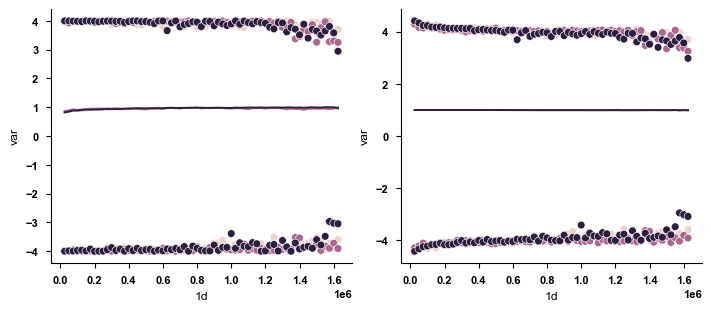

In [7]:
d1map = d1d[None,:] - d1d[:,None]
ls = {"axis":[], "1d":[], "var":[], "n":[]}
for i in range(arr.shape[1]):
    for d in np.unique(d1map[d1map>0]):
        ls["axis"].append(i)
        ls["1d"].append(d)
        sub_arr = arr[:,i,:,:][:,d1map==d]
        ls["var"].append(np.nanvar(sub_arr))
        ls["n"].append(np.sum(~np.isnan(sub_arr)))
var_df = pd.DataFrame(ls)

var_df["y_hat"] = var_df["var"]
var_df["std"] = np.sqrt(var_df["y_hat"])
std_sr = var_df.set_index(["axis", "1d"])["std"]

narr = np.zeros_like(arr) * np.nan
for i in range(arr.shape[1]):
    for d in np.unique(d1map[d1map>0]):
        idxs = np.where(np.abs(d1map)==d)
        narr[:,i,*idxs] = arr[:,i,*idxs]/std_sr[i,d]
if nstds is not None:
    narr[np.abs(narr) > nstds] = np.nan
farr = narr.copy()
for i in range(arr.shape[1]):
    for d in np.unique(d1map[d1map>0]):
        idxs = np.where(np.abs(d1map)==d)
        farr[:,i,*idxs] = narr[:,i,*idxs]/np.nanstd(narr[:,i,*idxs])
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
sns.scatterplot(to_var_df(narr, d1d, np.nanmax), 
                x="1d", y="var", hue="axis", ax=axes[0])
sns.scatterplot(to_var_df(narr, d1d, np.nanmin), 
                x="1d", y="var", hue="axis", ax=axes[0])
sns.lineplot(to_var_df(narr, d1d), x="1d", y="var", hue="axis", ax=axes[0])
axes[0].get_legend().set_visible(False)
sns.scatterplot(to_var_df(farr, d1d, np.nanmax), 
                x="1d", y="var", hue="axis", ax=axes[1])
sns.scatterplot(to_var_df(farr, d1d, np.nanmin), 
                x="1d", y="var", hue="axis", ax=axes[1])
sns.lineplot(to_var_df(farr, d1d), x="1d", y="var", hue="axis", ax=axes[1])
axes[1].get_legend().set_visible(False)

2. divide by the sample variance fitted by a order 4 polynomial (original, no final normalization)

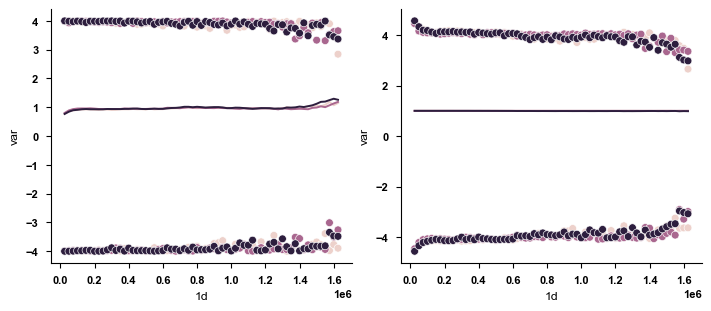

In [8]:
d1map = d1d[None,:] - d1d[:,None]
ls = {"axis":[], "1d":[], "var":[], "n":[]}
for i in range(arr.shape[1]):
    for d in np.unique(d1map[d1map>0]):
        ls["axis"].append(i)
        ls["1d"].append(d)
        sub_arr = arr[:,i,:,:][:,d1map==d]
        ls["var"].append(np.nanvar(sub_arr))
        ls["n"].append(np.sum(~np.isnan(sub_arr)))
var_df = pd.DataFrame(ls)

var_df["y_hat"] = np.concatenate([
    np.polyval(np.polyfit(
        x=df["1d"]/df["1d"].max(), 
        y=df["var"], w=df["n"], deg=4
    ), df["1d"]/df["1d"].max())
    for _, df in var_df.groupby("axis", sort=False)
])
var_df["std"] = np.sqrt(var_df["y_hat"])
std_sr = var_df.set_index(["axis", "1d"])["std"]

narr = np.zeros_like(arr) * np.nan
for i in range(arr.shape[1]):
    for d in np.unique(d1map[d1map>0]):
        idxs = np.where(np.abs(d1map)==d)
        narr[:,i,*idxs] = arr[:,i,*idxs]/std_sr[i,d]
if nstds is not None:
    narr[np.abs(narr) > nstds] = np.nan
# return narr
farr = narr.copy()
for i in range(arr.shape[1]):
    for d in np.unique(d1map[d1map>0]):
        idxs = np.where(np.abs(d1map)==d)
        farr[:,i,*idxs] = narr[:,i,*idxs]/np.nanstd(narr[:,i,*idxs])
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
sns.scatterplot(to_var_df(narr, d1d, np.nanmax), 
                x="1d", y="var", hue="axis", ax=axes[0])
sns.scatterplot(to_var_df(narr, d1d, np.nanmin), 
                x="1d", y="var", hue="axis", ax=axes[0])
sns.lineplot(to_var_df(narr, d1d), x="1d", y="var", hue="axis", ax=axes[0])
axes[0].get_legend().set_visible(False)
sns.scatterplot(to_var_df(farr, d1d, np.nanmax), 
                x="1d", y="var", hue="axis", ax=axes[1])
sns.scatterplot(to_var_df(farr, d1d, np.nanmin), 
                x="1d", y="var", hue="axis", ax=axes[1])
sns.lineplot(to_var_df(farr, d1d), x="1d", y="var", hue="axis", ax=axes[1])
axes[1].get_legend().set_visible(False)

3. divide by the median variance

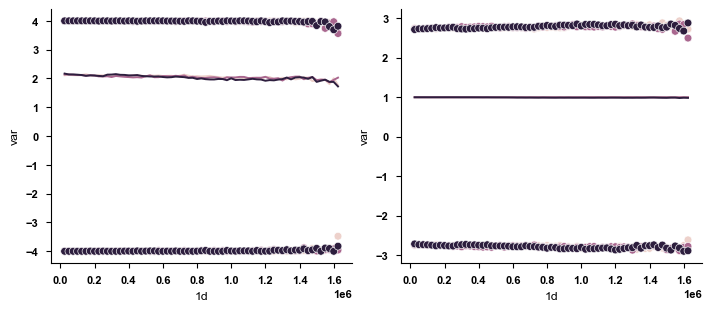

In [9]:
d1map = d1d[None,:] - d1d[:,None]
ls = {"axis":[], "1d":[], "var":[], "n":[]}
for i in range(arr.shape[1]):
    for d in np.unique(d1map[d1map>0]):
        ls["axis"].append(i)
        ls["1d"].append(d)
        sub_arr = arr[:,i,:,:][:,d1map==d]
        ls["var"].append(np.nanmedian(np.square(sub_arr)))
        ls["n"].append(np.sum(~np.isnan(sub_arr)))
var_df = pd.DataFrame(ls)

var_df["y_hat"] = var_df["var"]
var_df["std"] = np.sqrt(var_df["y_hat"])
std_sr = var_df.set_index(["axis", "1d"])["std"]

narr = np.zeros_like(arr) * np.nan
for i in range(arr.shape[1]):
    for d in np.unique(d1map[d1map>0]):
        idxs = np.where(np.abs(d1map)==d)
        narr[:,i,*idxs] = arr[:,i,*idxs]/std_sr[i,d]
if nstds is not None:
    narr[np.abs(narr) > nstds] = np.nan
farr = narr.copy()
for i in range(arr.shape[1]):
    for d in np.unique(d1map[d1map>0]):
        idxs = np.where(np.abs(d1map)==d)
        farr[:,i,*idxs] = narr[:,i,*idxs]/np.nanstd(narr[:,i,*idxs])
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
sns.scatterplot(to_var_df(narr, d1d, np.nanmax), 
                x="1d", y="var", hue="axis", ax=axes[0])
sns.scatterplot(to_var_df(narr, d1d, np.nanmin), 
                x="1d", y="var", hue="axis", ax=axes[0])
sns.lineplot(to_var_df(narr, d1d), x="1d", y="var", hue="axis", ax=axes[0])
axes[0].get_legend().set_visible(False)
sns.scatterplot(to_var_df(farr, d1d, np.nanmax), 
                x="1d", y="var", hue="axis", ax=axes[1])
sns.scatterplot(to_var_df(farr, d1d, np.nanmin), 
                x="1d", y="var", hue="axis", ax=axes[1])
sns.lineplot(to_var_df(farr, d1d), x="1d", y="var", hue="axis", ax=axes[1])
axes[1].get_legend().set_visible(False)

## Different test objects

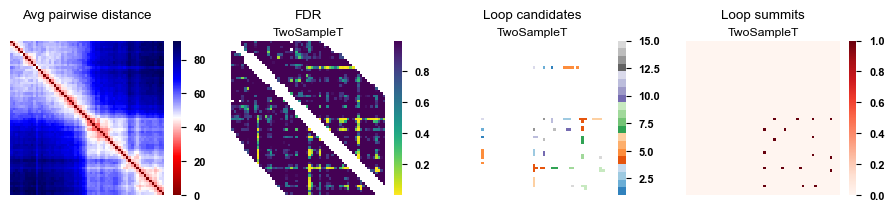

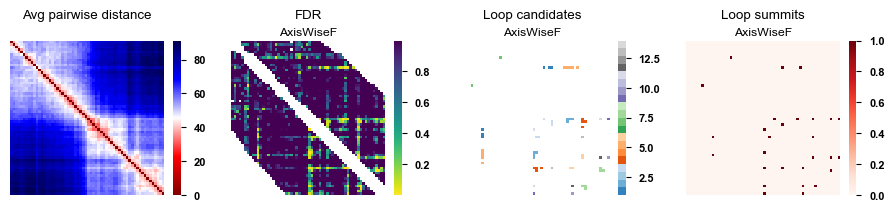

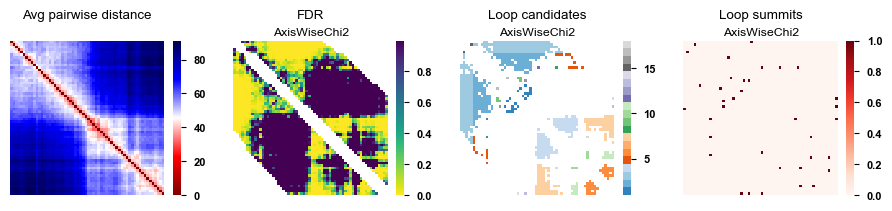

In [ ]:
chr_id = "chr3"
chr_df, arr = sf.utils.to_very_wide(mfr[chr_id])
dmaps = np.sqrt(np.sum(np.square(arr), axis=1))
slc = sf.loop.LoopCaller(mfr[chr_id])
for met in [sf.loop.TwoSampleT, sf.loop.AxisWiseF]:
    res = slc.loops_from_single_chr(chr_id, met)
    x = met.__name__
    fig, axes = plt.subplots(1, 4, figsize=(9, 2))
    sf.pl.pairwise_heatmap(dmaps, title=f"Avg pairwise distance", x=" ", ax=axes[0])
    sf.pl.pairwise_heatmap(X1=res["fdr"], x=x, title="FDR", cmap="viridis_r", ax=axes[1])
    sf.pl.pairwise_heatmap(X1=res["label"], x=x, title="Loop candidates", cmap="tab20c", ax=axes[2])
    sf.pl.pairwise_heatmap(X1=res["summit"], x=x, title="Loop summits", cmap="Reds", ax=axes[3])

## On-disk format

In [27]:
sdl = sf.loop.DiffLoop(
    data1=mfr[("Replicate", "rep1")],
    data2=mfr[("Replicate", "rep2")],
    zarr_dire="carr"
)

chr_id = "chr3"
carr = sf.utils.load.ChromArray(sdl._data[sdl._data["Chrom"]==chr_id])
carr.load_write(os.path.join(sdl._zarr_dire, chr_id))
carr.normalize_inplace(4)

In [85]:
# chr_df_pivoted, arr = sf.utils.load.to_very_wide(mfr["chr8"])
carr = sf.utils.load.ChromArray(mfr["chr8"])
carr.load_write("carr")
print(da.sum(~da.isnan(carr.arr)).compute())
carr.normalize_inplace()
print(da.sum(~da.isnan(carr.arr)).compute())

5260779
5123921


In [99]:
dc = sf.domain.TADCaller(mfr.data, 1e5, "carr")
tad_res = dc.by_pval(0.1)

In [35]:
entry_var = da.nanmean(da.square(carr.arr), axis=0).compute()
count = da.sum(~da.isnan(carr.arr), axis=0).compute()

In [73]:
window = 1e5
arr = carr.arr.compute()
d1d = carr.d1d
d = 3

i = 10

left, right = np.where(np.abs(d1d - d1d[i]) <= window)[0][[0,-1]]
ls, rs = slice(left, i), slice(i+1, right+1)

lcount = count[:,ls,ls][:,*np.triu_indices(i-left,1)]
rcount = count[:,rs,rs][:,*np.triu_indices(right-i,1)]
intra_count = np.hstack([lcount, rcount]).sum(axis=1)
lvar = entry_var[:,ls,ls][:,*np.triu_indices(i-left,1)]
rvar = entry_var[:,rs,rs][:,*np.triu_indices(right-i,1)]
var_nume = np.hstack([
    lvar*(lcount/intra_count[:,None]),
    rvar*(rcount/intra_count[:,None])
]).sum(axis=1)

inter_count = np.sum(count[:,ls,rs], axis=(1,2))
wts = count[:,ls,rs]/inter_count[:,None,None]
var_deno = np.sum(entry_var[:,ls,rs]*wts, axis=(1,2))

f_stats = var_nume/var_deno
stats.f.cdf(f_stats, intra_count, inter_count)

array([0.02060595, 0.00130401, 0.02762163])

In [71]:
lflat = arr[:,:,ls,ls][:,:,*np.triu_indices(i-left,1)]
lflat = lflat.transpose((1,0,2)).reshape(d,-1)
rflat = arr[:,:,rs,rs][:,:,*np.triu_indices(right-i,1)]
rflat = rflat.transpose((1,0,2)).reshape(d,-1)

flat_intra = np.hstack([lflat, rflat])
var_nume = np.nanmean(np.square(flat_intra), axis=1)

flat_inter = arr[:,:,ls,rs].transpose((1,0,2,3)).reshape(d,-1)
var_deno = np.nanmean(np.square(flat_inter), axis=1)

f_stats = var_nume/var_deno
n1 = np.sum(~np.isnan(flat_intra), axis=1)
n2 = np.sum(~np.isnan(flat_inter), axis=1)
f_pvals = stats.f.cdf(f_stats, n1, n2)

f_pvals

array([0.02060595, 0.00130401, 0.02762163])

### Approximation of normalization

In [102]:
chr_df = mfr["chr3"]
val_cols = ["X", "Y", "Z"]
chr_df_pivoted = chr_df.pivot_table(
    index="Chrom_Start", 
    columns="Trace_ID", 
    values=val_cols,
    sort=False
)
X = np.stack([
    chr_df_pivoted[v].values for v in val_cols
]).transpose(2, 1, 0)
d1d = chr_df_pivoted.index.values
carr = sf.utils.load.ChromArray(chr_df)
carr.load_write("test_zarr")

In [103]:
med_sq = da.nanmedian(da.square(carr.arr), axis=0).compute()
d1map = d1d[None,:] - d1d[:,None]
med_sqs = []
med_sqs2 = []
arrs = sf.utils.to_very_wide(chr_df)[1]
for dd in np.unique(d1map[d1map>0]):
    idx = np.where(d1map==dd)
    med_sqs.append(np.nanmedian(med_sq[:,*idx], axis=1)**.5)
    
    med_sqs2.append(np.nanmedian(np.square(arrs[:,:,*idx]), axis=(0,2))**.5)
med_sqs = np.stack(med_sqs)
med_sqs2 = np.stack(med_sqs2)

cols = ["X", "Y", "Z"]
d1 = pd.DataFrame(med_sqs, columns=cols)
d1["1d"] = np.unique(d1map[d1map>0])
d1 = d1.melt(id_vars="1d", value_name="k", var_name="axis")
d1["Method"] = "Approximated"

d2 = pd.DataFrame(med_sqs2, columns=cols)
d2["1d"] = np.unique(d1map[d1map>0])
d2 = d2.melt(id_vars="1d", value_name="k", var_name="axis")
d2["Method"] = "Full"
df = pd.concat([d1,d2])

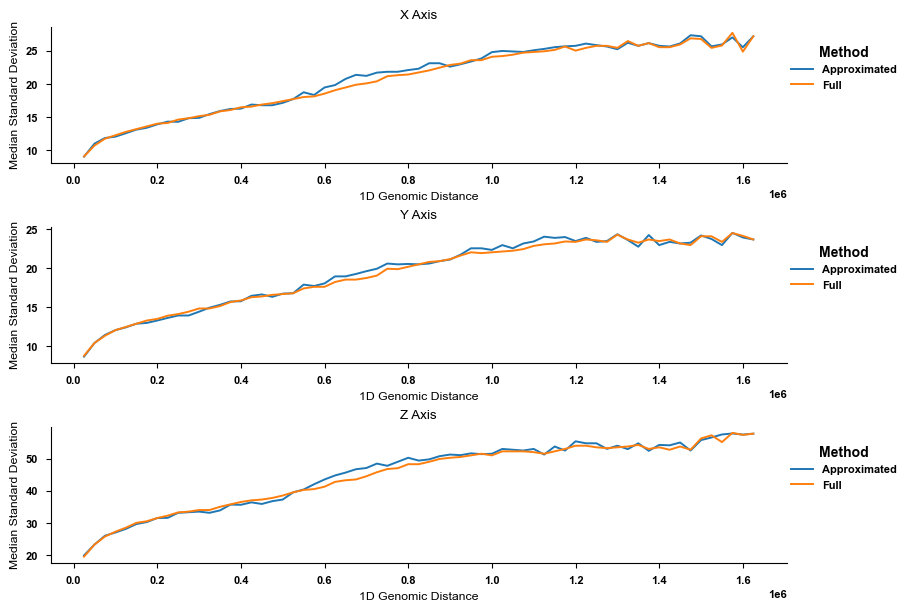

In [104]:
fig, axes = plt.subplots(3, 1, figsize=(9, 6))
for i, axis in enumerate(cols):
    sns.lineplot(df[df.axis==axis], x="1d", y="k", hue="Method", ax=axes[i])
    axes[i].set(xlabel="1D Genomic Distance", ylabel="Median Standard Deviation", 
                title=f"{axis} Axis")

## Compartment simulations

In [13]:
p, rho, n = 200, .5, 1000
B = np.array([
    [.15, .1],
    [.1, .12],
])
np.random.seed(0)
a1 = sf.simulate.ABSample(p, n, rho, B)
a2 = sf.simulate.ABSample(p, n, rho, B)

<Axes: >

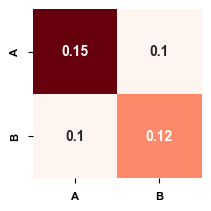

In [29]:
fig, ax = plt.subplots(figsize=(2,2))
sns.heatmap(B, annot=True, square=True, ax=ax, cbar=False, cmap="Reds", 
            xticklabels=["A", "B"], yticklabels=["A", "B"])

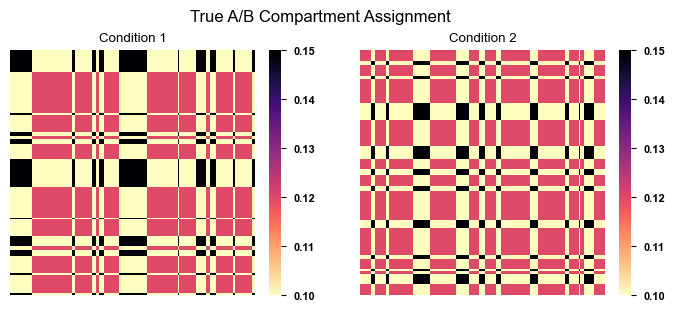

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle("True A/B Compartment Assignment")
sf.pl.pairwise_heatmap(a1.C@a1.B@a1.C.T, cmap="magma_r", title="Condition 1", ax=axes[0])
sf.pl.pairwise_heatmap(a2.C@a2.B@a2.C.T, cmap="magma_r", title="Condition 2", ax=axes[1])

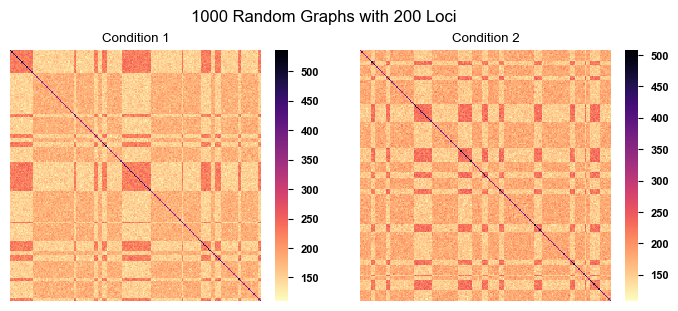

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
m1, m2 = np.sum(a1.samples, axis=(0,1)), np.sum(a2.samples, axis=(0,1))
fig.suptitle(f"{n} Random Graphs with {p} Loci")
sf.pl.pairwise_heatmap(m1, cmap="magma_r", title="Condition 1", ax=axes[0])
sf.pl.pairwise_heatmap(m2, cmap="magma_r", title="Condition 2", ax=axes[1])

In [ ]:
scpmt = sf.domain.ABCaller(mfr.data, 0)
scpmt.to_bedpe(scpmt.by_axes_pc())

,c1,s1,e1,cmpt
0,chr1,135600000,135625000,0
1,chr1,135625000,135650000,0
2,chr1,135650000,135675000,0
3,chr1,135675000,135700000,0
4,chr1,135700000,135725000,0
...,...,...,...,...
1195,chrX,76900457,76925457,1
1196,chrX,76925457,76950457,1
1197,chrX,76950457,76975457,1
1198,chrX,76975457,77000457,1


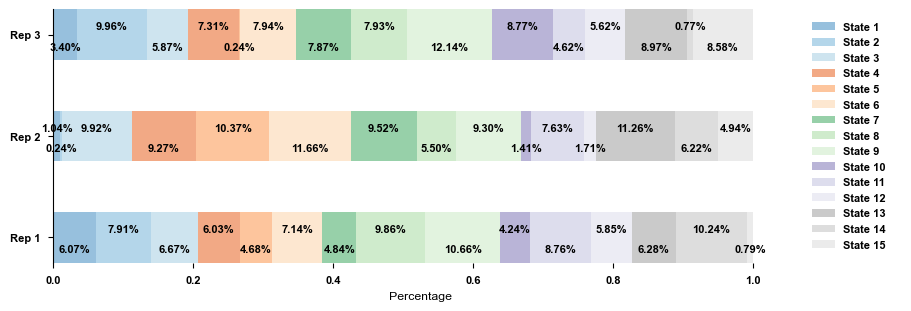

In [16]:
names = [f"State {i}" for i in range(1, 16)]
fracs = {}
np.random.seed(0)
for i in range(3):
    frac = np.random.uniform(0, 1, len(names))
    fracs[f"Rep {i+1}"] = frac/np.sum(frac)
df = pd.DataFrame(fracs, index=names).T
fig, axes = plt.subplots(1, 2, figsize=(9, 3), width_ratios=[7,1])
df.plot(kind="barh", stacked=True, colormap="tab20c", alpha=.5, ax=axes[0])
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().set_visible(False)
axes[0].set(xlabel="Percentage", ylim=(-.25,2.25))
axes[0].spines["bottom"].set_visible(False)
axes[1].axis("off")
axes[1].legend(handles=handles, labels=labels, loc="center")
# fig.tight_layout()

for i, bar in enumerate(axes[0].patches):
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_y()+.1+.2*(i%2),# + bar.get_height() / 2,
        f"{bar.get_width()*100:.2f}%", 
        fontsize=8, rotation=0, ha="center"
    )
    # axes[0].text(
    #     bar.get_x() + bar.get_width() / 2,
    #     bar.get_y()+.1, # + bar.get_height() / 2,
    #     f"{bar.get_width()*100:.2f}%", 
    #     fontsize=8, rotation=270, ha="center"
    # )